In [6]:
import random
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced

from gensim.models import Word2Vec, KeyedVectors

Using TensorFlow backend.


In [7]:
pd.set_option('display.max_colwidth', -1)

In [8]:
raw_data = pd.read_csv("train.csv")

In [9]:
raw_data.shape

(1306122, 3)

In [10]:
raw_data.columns

Index(['qid', 'question_text', 'target'], dtype='object')

In [8]:
raw_data["target"].value_counts()

0    1225312
1    80810  
Name: target, dtype: int64

In [7]:
from nltk.tokenize import TreebankWordTokenizer, WhitespaceTokenizer, WordPunctTokenizer

In [60]:
UpperDic_0 = {}
UpperDic_1 = {}
for index, row in raw_data.iterrows():
    text = row["question_text"]
    Ulist = re.findall(r'\b[A-Z]+\b', text)
#     Ulist = re.findall(r'\b[A-Z]+\w*\b', text)
    if(row["target"] == 0):
        for word in Ulist:
            if(word in UpperDic_0):
                UpperDic_0[word] += 1
            else:
                UpperDic_0[word] = 1
    else:
        for word in Ulist:
            if(word in UpperDic_1):
                UpperDic_1[word] += 1
            else:
                UpperDic_1[word] = 1


In [61]:
UpperList_0 = []
UpperList_1 = []
for key, val in UpperDic_0.items():
    tem = (key, val)
    UpperList_0.append(tem)

for key, val in UpperDic_1.items():
    tem = (key, val)
    UpperList_1.append(tem)

UpperList_0 = sorted(UpperList_0, key=lambda x:x[1], reverse=True)
UpperList_1 = sorted(UpperList_1, key=lambda x:x[1], reverse=True)

In [62]:
len(UpperList_0)

14171

In [63]:
len(UpperList_1)

2163

In [71]:
print(UpperList_0[:200])

[('I', 317207), ('US', 10574), ('A', 6488), ('JEE', 4918), ('USA', 4704), ('TV', 4531), ('IIT', 3983), ('B', 3815), ('UK', 3725), ('MBA', 3671), ('S', 3663), ('C', 3210), ('U', 3036), ('IT', 2993), ('CSE', 2626), ('UPSC', 2166), ('MS', 1984), ('CBSE', 1905), ('NEET', 1875), ('CA', 1871), ('M', 1808), ('CS', 1803), ('NIT', 1640), ('MBBS', 1554), ('SSC', 1499), ('PC', 1491), ('IAS', 1475), ('D', 1463), ('IQ', 1427), ('AI', 1332), ('GST', 1319), ('GATE', 1269), ('X', 1252), ('E', 1222), ('ECE', 1160), ('R', 1145), ('DC', 1136), ('CAT', 1066), ('BJP', 1064), ('EU', 1044), ('AIIMS', 1028), ('VIT', 993), ('MIT', 979), ('IIM', 956), ('SBI', 942), ('DNA', 924), ('CGL', 921), ('T', 890), ('PG', 860), ('SEO', 854), ('SAT', 835), ('BA', 827), ('GPA', 822), ('BITS', 807), ('OBC', 806), ('SC', 801), ('AC', 792), ('K', 789), ('P', 786), ('F', 758), ('II', 718), ('BBA', 717), ('GRE', 696), ('HR', 671), ('ICSE', 653), ('O', 651), ('SAP', 649), ('PO', 647), ('PR', 641), ('L', 640), ('AP', 638), ('PHP',

In [69]:
print(UpperList_1)

[('I', 12835), ('US', 2212), ('USA', 983), ('BJP', 575), ('UK', 574), ('U', 523), ('S', 513), ('IQ', 499), ('A', 360), ('ISIS', 270), ('PM', 261), ('FBI', 196), ('EU', 177), ('LGBT', 174), ('NRA', 149), ('TV', 149), ('RSS', 141), ('OK', 134), ('GOP', 125), ('UN', 105), ('CNN', 102), ('NASA', 90), ('IT', 85), ('DNA', 84), ('POTUS', 76), ('K', 70), ('B', 69), ('N', 68), ('CIA', 67), ('UP', 67), ('WWII', 67), ('D', 62), ('LGBTQ', 62), ('J', 61), ('IS', 60), ('IIT', 57), ('SC', 57), ('DNC', 56), ('SJW', 54), ('E', 53), ('AR', 53), ('II', 52), ('NOT', 52), ('NFL', 51), ('CM', 51), ('C', 51), ('AAP', 51), ('T', 50), ('WHY', 46), ('W', 43), ('KKK', 42), ('PC', 42), ('AND', 42), ('ST', 40), ('MS', 40), ('TO', 40), ('DACA', 39), ('JEE', 39), ('R', 39), ('NATO', 38), ('GDP', 38), ('P', 37), ('BS', 37), ('M', 36), ('O', 36), ('HIV', 35), ('YOU', 35), ('X', 34), ('F', 33), ('CCP', 33), ('AIDS', 31), ('FYROM', 31), ('ALL', 30), ('SO', 29), ('H', 27), ('DOJ', 26), ('BTS', 25), ('BBC', 25), ('EVM', 2

In [67]:
UpperDic_0["ISIS"]

445

## Split a test dataset for model selection

In [11]:
# 20% for test
from sklearn.model_selection import train_test_split
random.seed(1)
s = random.sample(range(raw_data.shape[0]), 500)
raw_data = raw_data.iloc[s, :]
train, val = train_test_split(raw_data, test_size=0.2, random_state=1, stratify=raw_data["target"])

In [12]:
train.shape

(400, 3)

In [13]:
val.shape

(100, 3)

In [14]:
train["target"].value_counts()

0    374
1    26 
Name: target, dtype: int64

In [15]:
val["target"].value_counts()

0    94
1    6 
Name: target, dtype: int64

In [16]:
val.to_csv(path_or_buf="~/Documents/CS548KDD/project5/val.csv", index=False)

In [17]:
train.to_csv(path_or_buf="~/Documents/CS548KDD/project5/train1.csv", index=False)

0    245063
1    16162 
Name: target, dtype: int64

In [58]:
1050000*0.00005

52.5

In [23]:
sw = stopwords.words("english")
print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [47]:
a = "I haven't been there're his yours.  s??"
re.split(r'[\s,.?]+', a)

['I', "haven't", 'been', "there're", 'his', 'yours', 's', '']

In [46]:
[word for word in re.split(r'[\s,.?]+', a) if word not in sw]

['I', "there're", '']

In [50]:
b = "fsf2313 sfsf2 sf2 212sf, fs2fs 23"
re.sub(r'\d', '', b)

'fsf sfsf sf sf, fsfs '

In [5]:
# remove qid and resample unblanced data
raw_data = raw_data[["question_text", "target"]]
# undersampling
sampler = RandomUnderSampler(random_state=1)
X, y = sampler.fit_resample(raw_data.loc[:, raw_data.columns != "target"], raw_data["target"])

In [8]:
X.shape

(161620, 1)

In [10]:
print(np.unique(y, return_counts=True))

(array([0, 1]), array([80810, 80810]))


In [44]:

df = pd.DataFrame(data=X[:,], columns=["question"], copy=True)
df["target"] = y

## Explore data

In [14]:
# how many rows contain "**"
def find_mark(text):
    match = re.search(r'\*+', text)
#     match = re.search(r'\*{2,}', text)
    a = 0
    if(match):
        a = 1
    return a
df["contain *"] = df["question"].apply(find_mark)

In [15]:
df[df["contain *"]==1]["target"].value_counts()

1    136
0    39 
Name: target, dtype: int64

In [85]:
sum(df["contain *"])
# 57 questions contain more than 2 "*"s, and 55 are insane questions
# when a sentence contains more than 2 "*"s, it is most likely to be a insane question

175

In [ ]:
# The result indicates that we can remove * without missing too much information

## Test on  small set of data

In [59]:
# randomly select 10,000 data 
random.seed(1)
s = random.sample(range(df.shape[0]), 1000)
df_s = df.iloc[s, :]

NameError: name 'df' is not defined

In [290]:
# how many contain "*"
df_s["contain *"] = df_s["question"].apply(find_mark)
df_s[df_s["contain *"] == 1]["target"].value_counts()

/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


1    7
0    2
Name: target, dtype: int64

In [291]:
df_s = df_s.reset_index(drop=True)

In [292]:
df_s["target"].value_counts()

0    5006
1    4994
Name: target, dtype: int64

In [293]:
df_s = df_s[["question", "target"]]

In [264]:
df_s.shape

(10000, 2)

In [265]:
df_s.head()

,question,target
0,What has exactly changed in terms of data entry trends over the years?,0
1,Why do people say that Italian Football Players/Azzurri are cheaters?,1
2,What would Japan be like if they never invaded any country?,0
3,What would happen if everyone who died between the 5th and 15th century came back to life in good health?,0
4,What are the special techniques in Dialer Service?,0


In [35]:
df_s.iloc[[26, 94, 214, 241, 475],]

,question,target
26,Where do I go if I want to go to Paris?,1
94,Why is everyone so pretentious on Quora?,1
214,What are the world’s top 10 tallest buildings in 2017?,1
241,Why do we need brains?,1
475,Why do boys ask girls for their phone number in the first conversation itself making it awkward and irritating?,1


In [42]:
df_s[df_s["target"] == 0][105:110]

,question,target
221,What are primary and secondary modeling types used in microbiological modeling?,0
224,What are some examples of using the API composition pattern in microservices?,0
226,What is the main cause of air pollution in China?,0
228,Can single soldiers without dependents (E4) own a home using the VA loan?,0
230,How do I become a nudist at 14 without my parents knowing?,0


## Remove irrelative stuff

In [57]:
# remvove punctuation except "*"
def punctuation_remove(text):
    return re.sub(r'[^\w\s\*]', '', text)
df_s["question"] = df_s["question"].apply(punctuation_remove)

In [59]:
# check if function above works
df_s["contain *"] = df_s["question"].apply(find_mark)
df_s["contain *"].sum()

9

In [60]:
df_s[df_s["contain *"] == 1]

,question,target,contain *
1524,Why are ind*a*s so poor at organizing things,1,1
1811,Can I get mechanical engineering at IIT Roorkee with gen rank 263*,0,1
2550,Why do fat women wear yoga pantsleggings dont they realize how **** they look,1,1
2832,The first days of June Samantha Bee calls Ivanka a feckless c*nt Bill Maher hopes the economy crashes Robert De Niro screams F*ck Trump at the Tony Awards And theyre the ones worried about President Trumps mental heath,1,1
3558,Why do people ask such seemingly stupid questions in mathematics Scrolling my feed I just saw Whats 11*1 Which is greater 32 62 4 or 94 and of course the person arguing that theres no such thing as division Do they really not know,1,1
4983,How does pressure P becomes P curlPcurlX *dX after travelling a short distance dX by curl I meant partial derivative,0,1
6359,Why is President Trumps *temporary* refugee ban such a bad idea Dont 50 of Americans support it,1,1
7252,Why does big boobed girls look s**ty I have big ones,1,1
8654,What would happen if you sent a letter to Donald Trump saying f*** you You deserve to die,1,1


In [297]:
# remvove punctuation
def punctuation_remove_all(text):
    return re.sub(r'[^\w\s]', '', text)
df_s["question"] = df_s["question"].apply(punctuation_remove_all)

In [62]:
df_s[df_s["contain *"] == 1]

,question,target,contain *
1524,Why are indas so poor at organizing things,1,1
1811,Can I get mechanical engineering at IIT Roorkee with gen rank 263,0,1
2550,Why do fat women wear yoga pantsleggings dont they realize how they look,1,1
2832,The first days of June Samantha Bee calls Ivanka a feckless cnt Bill Maher hopes the economy crashes Robert De Niro screams Fck Trump at the Tony Awards And theyre the ones worried about President Trumps mental heath,1,1
3558,Why do people ask such seemingly stupid questions in mathematics Scrolling my feed I just saw Whats 111 Which is greater 32 62 4 or 94 and of course the person arguing that theres no such thing as division Do they really not know,1,1
4983,How does pressure P becomes P curlPcurlX dX after travelling a short distance dX by curl I meant partial derivative,0,1
6359,Why is President Trumps temporary refugee ban such a bad idea Dont 50 of Americans support it,1,1
7252,Why does big boobed girls look sty I have big ones,1,1
8654,What would happen if you sent a letter to Donald Trump saying f you You deserve to die,1,1


In [194]:
# find out how many questions contain numbers
# how many rows contain numbers
def find_number(text):
    match = re.search(r'\d+', text)
    a = 0
    if(match):
        a = 1
    return a
df_s["contain num"] = df_s["question"].apply(find_number)

In [195]:
df_s["contain num"].sum()

0

In [253]:
df_s[df_s["contain num"] == 1][:10]

,question,target,contain num


In [298]:
# remove digit
def digit_remove(text):
    return re.sub(r'\d+', '', text)
df_s["question"] = df_s["question"].apply(digit_remove)

In [383]:
# lowercase words
# because stopwords are in lower case
def lower_word(text):
    return text.lower()
df_s["question"] = df_s["question"].apply(lower_word)

In [299]:
# remove stopwords
sw = stopwords.words("english")
def sw_remove(text):
    t = " ".join([word for word in text.split() if word not in sw])
    return t
df_s["question"] = df_s["question"].apply(sw_remove)

In [51]:
# stem words
stemmer = SnowballStemmer("english")
def stem_word(text):
    t = " ".join([stemmer.stem(word) for word in text.split()])
    return t
# df_s["question"] = df_s["question"].apply(stem_word)
stem_word("he's ours yours")

'he our your'

In [230]:
df_s.head()

,question,target,contain num
0,what exact chang term data entri trend year,0,0
1,whi peopl say italian footbal playersazzurri cheater,1,0
2,what would japan like never invad countri,0,0
3,what would happen everyon die th th centuri came back life good health,0,0
4,what special techniqu dialer servic,0,0


# Encode Text

## Bag-of-words (CountVectorizer)

In [197]:
# BOW encode sentences
# try some max_df, min_df
c_vectorizer = CountVectorizer(max_df=0.9, min_df=0.0005, lowercase=False)
doc_mat = c_vectorizer.fit_transform(df_s["question"]).toarray()

In [198]:
doc_mat.shape

(10000, 2841)

In [85]:
# when considering *, please run this chunk
doc_mat = np.append(doc_mat, np.array(df_s["contain *"]).reshape(-1, 1), axis=1)

In [199]:
doc_mat.shape

(10000, 2841)

In [200]:
m = c_vectorizer.get_feature_names()

In [201]:
k = 0
for a in m:
    if(re.search(r'[0-9]+', a)):
        k += 1
print(k)

0


## TD-IDF

In [231]:
# Tf-IDF encode sentences
vec = TfidfVectorizer(max_df=0.9, min_df=0.0005, lowercase=False)
doc_mat = vec.fit_transform(df_s["question"]).toarray()

In [ ]:
# when considering *, please run this chunk
doc_mat = np.append(doc_mat, np.array(df_s["contain *"]).reshape(-1, 1), axis=1)

In [232]:
doc_mat.shape

(10000, 2562)

## Word2Vec use pre-trained data

In [269]:
model_w2v = KeyedVectors.load_word2vec_format(
    "./embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin", binary=True)

In [270]:
# use average 
def avg_sentence(text):
    v = np.zeros(300)
    word_ls = text.split()
    for word in word_ls:
        if word in model_w2v:
            v += model_w2v[word]
    return v / len(word_ls)

In [271]:
doc_mat = np.zeros((10000, 300))
for index, row in df_s.iterrows():
    doc_mat[index, :] = avg_sentence(row["question"]).reshape(1, -1)

In [ ]:
# when considering *, please run this chunk
doc_mat = np.append(doc_mat, np.array(df_s["contain *"]).reshape(-1, 1), axis=1)

In [5]:
import io
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding="utf-8", newline="\n", errors="ignore")
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(" ")
        data[tokens[0]] = map(float, tokens[1:])
    return data

d = load_vectors("./embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec")

In [6]:
type(d)

dict

In [7]:
d["i"]

In [8]:
import numpy as np
def load_glove(fname):
    model = {}
    f = open(fname, "r")
    for line in f:
        wv_ls = line.split()
        word = "".join(wv_ls[:-300])
        embeddings = np.array(wv_ls[-300:], dtype="float32")
        model[word] = embeddings
    return model


# with open("./embeddings/glove.840B.300d/glove.840B.300d.txt") as f:
#     d = []
#     for line in f:
#         d.append(line)
d = load_glove("./embeddings/glove.840B.300d/glove.840B.300d.txt")

In [10]:
d["i"]

array([ 1.8733e-01,  4.0595e-01, -5.1174e-01, -5.5482e-01,  3.9716e-02,
        1.2887e-01,  4.5137e-01, -5.9149e-01,  1.5591e-01,  1.5137e+00,
       -8.7020e-01,  5.0672e-02,  1.5211e-01, -1.9183e-01,  1.1181e-01,
        1.2131e-01, -2.7212e-01,  1.6203e+00, -2.4884e-01,  1.4060e-01,
        3.3099e-01, -1.8061e-02,  1.5244e-01, -2.6943e-01, -2.7833e-01,
       -5.2123e-02, -4.8149e-01, -5.1839e-01,  8.6262e-02,  3.0818e-02,
       -2.1253e-01, -1.1378e-01, -2.2384e-01,  1.8262e-01, -3.4541e-01,
        8.2611e-02,  1.0024e-01, -7.9550e-02, -8.1721e-01,  6.5621e-03,
        8.0134e-02, -3.9976e-01, -6.3131e-02,  3.2260e-01, -3.1625e-02,
        4.3056e-01, -2.7270e-01, -7.6020e-02,  1.0293e-01, -8.8653e-02,
       -2.9087e-01, -4.7214e-02,  4.6036e-02, -1.7788e-02,  6.4990e-02,
        8.8451e-02, -3.1574e-01, -5.8522e-01,  2.2295e-01, -5.2785e-02,
       -5.5981e-01, -3.9580e-01, -7.9849e-02, -1.0933e-02, -4.1722e-02,
       -5.5576e-01,  8.8707e-02,  1.3710e-01, -2.9873e-03, -2.62

In [1]:
p = []
with open("./embeddings/paragram_300_sl999/paragram_300_sl999.txt", 'rb') as f:
    for line in f:
        p.append(line)

In [5]:
p[200].split()

[b'both',
 b'0.0530177342553',
 b'0.0192004575339',
 b'-0.617869694931',
 b'-0.100963766833',
 b'0.597887559812',
 b'-0.000657082215663',
 b'-0.106810133658',
 b'-0.583829581767',
 b'0.221955002123',
 b'2.35238860728',
 b'-0.0716129387945',
 b'0.462134724661',
 b'0.429236338223',
 b'-0.396457335565',
 b'0.0861289057046',
 b'0.121516466468',
 b'-0.0658045042025',
 b'1.439977497',
 b'-0.908099429974',
 b'-0.124203897772',
 b'-0.646132569589',
 b'-0.0954488506702',
 b'-0.453316526142',
 b'0.158391038721',
 b'0.0694987142862',
 b'-0.00138606492339',
 b'-0.35656672064',
 b'0.229827856381',
 b'0.549165626331',
 b'0.133837413388',
 b'-0.613212050545',
 b'0.261809851667',
 b'0.45898812971',
 b'0.083232176488',
 b'-0.353442441689',
 b'-0.268841752462',
 b'-0.223317357996',
 b'-0.231740124196',
 b'-0.138664609712',
 b'-0.646449673397',
 b'-0.431069852649',
 b'0.620571866686',
 b'-0.176085168724',
 b'-0.0314464023638',
 b'-0.329117895992',
 b'-0.130911759861',
 b'-0.262993198454',
 b'0.3088107194

In [3]:
showcase = 100
test = 97 + 89 + 105 + 96 + 96
project = 83 + 83 + 100 + 99 + 80
presentation = 100 + 90 + 95 + 94 + 80
participation = 90
test*0.11 + project*0.06 + presentation*0.005 + showcase*0.1 #+ participation*0.025

92.125

## Explore raw data to look for other possible approaches to encode text

In [304]:
# word frequency of each target
word_fre_dic_0 = {}
word_fre_dic_1 = {}
for index, row in df_s.iterrows():
    word_ls = row["question"].split()
    if(row["target"] == 1):
        for word in word_ls:
            if(word in word_fre_dic_1):
                word_fre_dic_1[word] += 1
            else:
                word_fre_dic_1[word] = 1
    else:
        for word in word_ls:
            if(word in word_fre_dic_0):
                word_fre_dic_0[word] += 1
            else:
                word_fre_dic_0[word] = 1
            
# sort
sorted_0 = [(key, word_fre_dic_0[key]) for key in word_fre_dic_0]
sorted_1 = [(key, word_fre_dic_1[key]) for key in word_fre_dic_1]
sorted_0 = sorted(sorted_0, key=lambda x: x[1], reverse=True)
sorted_1 = sorted(sorted_1, key=lambda x: x[1], reverse=True)


In [305]:
print(len(sorted_1))
print(sorted_1[50:100])


6993
[('presid', 104), ('gay', 104), ('take', 103), ('call', 101), ('much', 101), ('jew', 99), ('can', 99), ('america', 99), ('god', 97), ('true', 96), ('when', 95), ('live', 93), ('look', 93), ('good', 93), ('state', 91), ('donald', 90), ('guy', 90), ('obama', 89), ('realli', 89), ('should', 88), ('woman', 87), ('man', 86), ('becom', 85), ('china', 85), ('know', 83), ('im', 83), ('gun', 82), ('cant', 81), ('ask', 81), ('love', 80), ('see', 79), ('allow', 79), ('time', 78), ('bad', 78), ('ever', 78), ('human', 77), ('consid', 77), ('rape', 77), ('will', 77), ('person', 76), ('still', 76), ('come', 75), ('way', 75), ('islam', 75), ('isnt', 74), ('thing', 74), ('answer', 74), ('sinc', 73), ('children', 73), ('race', 72)]


In [306]:
print(len(sorted_0))
print(sorted_0[:50])

7485
[('what', 1784), ('i', 1194), ('how', 1017), ('whi', 480), ('is', 399), ('get', 315), ('best', 239), ('would', 238), ('like', 234), ('can', 209), ('use', 187), ('peopl', 177), ('good', 169), ('which', 167), ('one', 141), ('do', 129), ('make', 123), ('india', 121), ('if', 120), ('way', 110), ('are', 110), ('time', 109), ('work', 104), ('who', 103), ('differ', 101), ('year', 97), ('life', 96), ('go', 94), ('doe', 93), ('someon', 92), ('think', 91), ('mani', 88), ('take', 84), ('engin', 82), ('feel', 80), ('know', 79), ('person', 79), ('need', 78), ('want', 78), ('ever', 78), ('much', 77), ('univers', 76), ('thing', 76), ('happen', 75), ('start', 75), ('find', 74), ('student', 74), ('day', 73), ('where', 73), ('mean', 73)]


In [402]:
# get different words of two targets
wds_1 = [key for key in word_fre_dic_1]
wds_0 = [key for key in word_fre_dic_0]
# wds_1.remove(list(set(wds_1).intersection(wds_0)))
for word in list(set(wds_1).intersection(wds_0)):
    wds_1.remove(word)
    wds_0.remove(word)

In [403]:
print(len(wds_1))
print(len(wds_0))

3544
4046


In [408]:
print(wds_1[:30])
print("")
print(wds_0[:30])

['playersazzurri', 'crossbre', 'slut', 'progun', 'lobbi', 'ossoff', 'instig', 'underserv', 'hostil', 'gentil', 'ethnic', 'caucasian', 'inferior', 'disapprov', 'hrc', 'discriminatori', 'fetish', 'pari', 'tackl', 'allpow', 'allknow', 'punjabi', 'hindus', 'sikh', 'mud', 'brick', 'flood', 'unintellig', 'ndiqn', 'shamelss']

['techniqu', 'dialer', 'risefal', 'recov', 'download', 'chrome', 'architect', 'exhaust', 'charadepattern', 'heartbeat', 'horizont', 'longstand', 'undergradu', 'iona', 'cse', 'mit', 'manip', 'muoet', 'qanta', 'cabin', 'crew', 'devic', 'perchlor', 'goodread', 'applic', 'stapl', 'salient', 'pinkberri', 'ionic', 'crystal']


In [411]:
# a = ["haha", "lol", "heihei"]
# def w2d(text):
#     wl = text.split()
#     for w in wl:
#         if(w in a):
#             i = a.index(w)
#             m[i] += 1
Word_list = wds_0 + wds_1

In [414]:
doc_mat = np.zeros((10000, len(Word_list)))
for index, row in df_s.iterrows():
    wl = row["question"].split()
    for word in wl:
        if(word in Word_list):
            doc_mat[index, Word_list.index(word)] += 1

0.0

## Combine words matrix and target

In [272]:
# combine words matrix and target
doc_mat = np.append(doc_mat, np.array(df_s["target"]).reshape(-1, 1), axis=1)

In [273]:
doc_mat.shape

(10000, 301)

## Split data into training, validation, and testing data set

In [274]:
random.seed(2)
# get test dataset
t = random.sample(range(doc_mat.shape[0]), k=int((doc_mat.shape[0])*0.2))
test = doc_mat[t, ]
mask = np.ones(doc_mat.shape[0], dtype=bool)
mask[t] = False
train_val = doc_mat[mask, ]
# get validation dataset
v = random.sample(range(train_val.shape[0]), k=int((train_val.shape[0])*0.2))
val = train_val[v, ]
mask_1 = np.ones(train_val.shape[0], dtype=bool)
mask_1[v] = False
train = train_val[mask_1, ]

In [275]:
print(train.shape)
print(val.shape)
print(test.shape)


(6400, 301)
(1600, 301)
(2000, 301)


In [276]:
print(np.unique(train[:, -1], return_counts=True))
print(np.unique(test[:, -1], return_counts=True))
print(np.unique(val[:, -1], return_counts=True))

(array([0., 1.]), array([3158, 3242]))
(array([0., 1.]), array([1053,  947]))
(array([0., 1.]), array([795, 805]))


## Decision Tree

In [247]:
tree_clf = DecisionTreeClassifier(criterion="entropy", random_state=2)
tree_clf.fit(train_val[:, :train_val.shape[1]-1], train_val[:, -1])

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=2,
            splitter='best')

In [248]:
pred = tree_clf.predict(test[:, :test.shape[1]-1])
print(confusion_matrix(test[:, -1], pred, labels=[1, 0]).T)

[[713 210]
 [234 843]]


In [249]:
print(classification_report_imbalanced(test[:, -1], pred))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.78      0.80      0.75      0.79      0.78      0.61      1053
        1.0       0.77      0.75      0.80      0.76      0.78      0.60       947

avg / total       0.78      0.78      0.78      0.78      0.78      0.60      2000



In [250]:
imp = tree_clf.feature_importances_
imp.argsort()[::-1][:20]

array([2489, 2498, 1088, 2358, 1664, 2021, 2499, 1149, 2527, 1503,  346,
       1206,  964, 1322,  966, 2501,  276, 1110,   89, 2539])

In [251]:
# 20 most important words for decision tree
# for BOW and TF-IDF
# mapper = c_vectorizer.get_feature_names()
mapper = vec.get_feature_names()
for i in imp.argsort()[::-1][:20]:
    print(mapper[i])

what
whi
how
trump
peopl
sex
which
indian
women
muslim
can
is
get
liber
girl
white
black
if
american
would


In [238]:
## try GridSearchCV
t_clf = DecisionTreeClassifier(criterion="entropy", random_state=2)
parameters = {"max_depth": [10, 15, 20], "min_samples_split": [0.05, 0.1, 0.15]}
t_clfs = GridSearchCV(t_clf, parameters, scoring="f1", cv=5, refit=True)
t_clfs.fit(train_val[:, :train_val.shape[1]-1], train_val[:, -1])

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=2,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [10, 15, 20], 'min_samples_split': [0.05, 0.1, 0.15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [239]:
pred_ts = t_clfs.predict(test[:, :test.shape[1]-1])
confusion_matrix(test[:, -1], pred_ts, labels=[1, 0]).T

array([[615, 142],
       [332, 911]])

In [240]:
print(classification_report_imbalanced(test[:, -1], pred_ts))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.73      0.87      0.65      0.79      0.75      0.57      1053
        1.0       0.81      0.65      0.87      0.72      0.75      0.55       947

avg / total       0.77      0.76      0.75      0.76      0.75      0.56      2000



In [254]:
# export tree 
ft = tree_clf.tree_.feature

In [258]:
th = tree_clf.tree_.threshold

In [259]:
th[:10]

array([0.13032014, 0.02801134, 0.14969358, 0.06585556, 0.14210411,
       0.11190711, 0.05779069, 0.06949547, 0.0745539 , 0.06554352])

## Artifacial Neural Network

In [277]:
train_target = to_categorical(train[:, -1])
val_target = to_categorical(val[:, -1])
# test_target = to_categorical(test[:, -1])

In [278]:
# random.seed(3)
random.seed(5)

model = Sequential()
model.add(Dense(1000, input_shape=(train.shape[1]-1, ), kernel_initializer='random_normal'))
model.add(Activation("relu"))
model.add(Dense(500, activation="relu", kernel_initializer="random_normal"))
# model.add(Dense(100, activation="relu", kernel_initializer="random_normal", bias_initializer="random_normal"))
model.add(Dense(2, kernel_initializer='random_normal')) # last layer
model.add(Activation('softmax'))
# Compile Model
model.compile(optimizer='sgd',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
history = model.fit(train[:, :train.shape[1]-1], train_target, 
                    validation_data = (val[:, :val.shape[1]-1], val_target), 
                    epochs=20, 
                    batch_size=128)

Train on 6400 samples, validate on 1600 samples
Epoch 1/20
6400/6400 [==============================] - 1s 161us/step - loss: 0.6926 - acc: 0.5189 - val_loss: 0.6882 - val_acc: 0.5513
Epoch 2/20
6400/6400 [==============================] - 1s 97us/step - loss: 0.6818 - acc: 0.6108 - val_loss: 0.6781 - val_acc: 0.6238
Epoch 3/20
6400/6400 [==============================] - 1s 100us/step - loss: 0.6712 - acc: 0.6761 - val_loss: 0.6679 - val_acc: 0.7081
Epoch 4/20
6400/6400 [==============================] - 1s 104us/step - loss: 0.6602 - acc: 0.7548 - val_loss: 0.6571 - val_acc: 0.7669
Epoch 5/20
6400/6400 [==============================] - 1s 98us/step - loss: 0.6485 - acc: 0.7880 - val_loss: 0.6456 - val_acc: 0.7956
Epoch 6/20
6400/6400 [==============================] - 1s 104us/step - loss: 0.6359 - acc: 0.8097 - val_loss: 0.6332 - val_acc: 0.8063
Epoch 7/20
6400/6400 [==============================] - 1s 94us/step - loss: 0.6223 - acc: 0.8220 - val_loss: 0.6196 - val_acc: 0.8187
Epo

In [279]:
def plot_acc(hist):
    fig, ax = plt.subplots(1, 1)
    ax.plot(hist.history["acc"], color="b", label="Training Accuracy")
    ax.plot(hist.history["val_acc"], color="r", label="Validation Accuracy")
    legend = ax.legend(loc="best", shadow=True)
    plt.show()

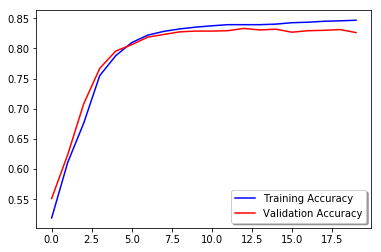

In [280]:
plot_acc(history)

In [281]:
pred_nn = model.predict(test[:, :test.shape[1]-1])
confusion_matrix(test[:, -1], np.argmax(pred_nn, axis=1), labels=[1, 0]).T

array([[791, 163],
       [156, 890]])

In [282]:
print(classification_report_imbalanced(test[:, -1], np.argmax(pred_nn, axis=1)))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.85      0.85      0.84      0.85      0.84      0.71      1053
        1.0       0.83      0.84      0.85      0.83      0.84      0.71       947

avg / total       0.84      0.84      0.84      0.84      0.84      0.71      2000



## Random Forest

In [283]:
rf_clf = RandomForestClassifier(criterion="entropy", max_depth=10, random_state=1)
rf_clf.fit(train_val[:, :train_val.shape[1]-1], train_val[:, -1])
rf_pred = rf_clf.predict(test[:, :test.shape[1]-1])


/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [285]:
confusion_matrix(test[:, -1], rf_pred, labels=[1, 0]).T

array([[773, 201],
       [174, 852]])

In [288]:
print(classification_report_imbalanced(test[:, -1], rf_pred))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.83      0.81      0.82      0.82      0.81      0.66      1053
        1.0       0.79      0.82      0.81      0.80      0.81      0.66       947

avg / total       0.81      0.81      0.81      0.81      0.81      0.66      2000



## Logistic Regression

In [120]:
# from sklearn.linear_model import LogisticRegression
# lg_clf = LogisticRegression(random_state=1)
# lg_clf.fit(train[:, :train.shape[1]-1], train[:, -1])

In [121]:
# pred_lg = lg_clf.predict(test[:, :test.shape[1]-1])
# print(confusion_matrix(test[:, -1], pred_lg, labels=[0, 1]).T)

In [122]:
# print(classification_report_imbalanced(test[:, -1], pred_lg))

## SVM

In [123]:
# svc = SVC(C=10, gamma="auto", random_state=1)
# svc.fit(train[:, :train.shape[1]-1], train[:, -1])

In [124]:
# pred_svc = svc.predict(test[:, :test.shape[1]-1])
# print(confusion_matrix(test[:, -1], pred_svc, labels=[0, 1]).T)